In [4]:
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.special import logit, expit
from scipy.stats import gaussian_kde
import numpy as np 
plt.style.use('seaborn')
from statsmodels.distributions import ECDF

from seaborn import kdeplot

In [5]:
filenames = ['label_correlation', 'hpo_implicit_als', 'hpo_implicit_bpr',
             'hpo_lightfm_warp', 'hpo_lightfm_bpr', 'nearest_neighbor']

yrs = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
num_targets = [225, 228, 231, 234, 237, 240, 242, 243, 243, 243]
year = 2015

def plot_fig_label(ax, lab):
    ax.text(0, 1.15, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

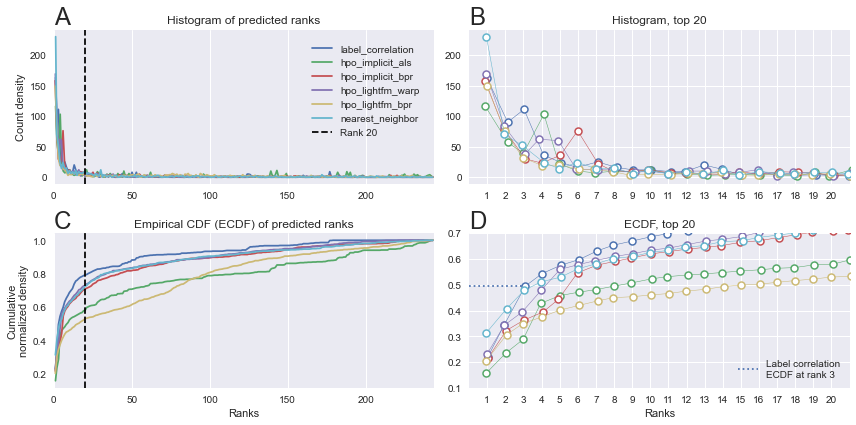

In [6]:
if True:
    ##Plot second figure:
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    ax1 = ax[0,0]
    ax2 = ax[0,1]
    ax3 = ax[1,0]
    ax4 = ax[1,1]


    for name in filenames:
        ranks = np.load('./processed_data/'+str(year)+'_'+name+'.npy')

        ##Plot histogram:
        n, x = np.histogram(ranks, bins = np.linspace(1,244,244))
        ax1.plot(x[:-1]+np.random.uniform(-0.15,0.15,len(n)),n, label=name)
        ax2.plot(x[:-1]+np.random.uniform(-0.15,0.15,len(n)),n,'-o', mfc='white', mew=1.5, label=name, linewidth=0.5)

        ##Plot empirical cumulative distribution function
        ecdf = np.cumsum(n)/n.sum()
        ax3.plot(x[:-1]+np.random.uniform(-0.1,0.1,len(n)),ecdf)
        ax4.plot(x[:-1]+np.random.uniform(-0.1,0.1,len(n)),ecdf, '-o', mfc='white', mew=1.5, linewidth=0.5)
        if name == 'label_correlation':
            ax4.plot([0,3],[ecdf[2],ecdf[2]],c='C0', linestyle=':',label='Label correlation\nECDF at rank 3')


    ax1.set_title('Histogram of predicted ranks')
    ax1.set_ylabel('Count density')
    ax1.yaxis.grid()
    ax1.axvline(20, linestyle='--', c='k', label='Rank 20')
    ax1.set_xlim(0,244)
    plot_fig_label(ax1, 'A')
    
    ax2.set_xlim(0,21)
    ax2.set_title('Histogram, top 20')
    ax2.set_xticks(np.arange(1,21,1))
    plot_fig_label(ax2, 'B')
    
    ax3.set_xlim(0,244)
    ax3.set_title('Empirical CDF (ECDF) of predicted ranks')
    ax3.set_ylabel('Cumulative\nnormalized density')
    ax3.yaxis.grid()
    ax3.axvline(20, linestyle='--', c='k')
    ax3.set_xlabel('Ranks')
    plot_fig_label(ax3, 'C')

    ax4.set_xlim(0,21)
    ax4.set_ylim(0.1, 0.7)
    ax4.set_title('ECDF, top 20')
    ax4.legend()
    ax4.set_xticks(np.arange(1,21,1))
    ax4.set_xlabel('Ranks')
    plot_fig_label(ax4, 'D')

    ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    plt.tight_layout()

<AxesSubplot:>

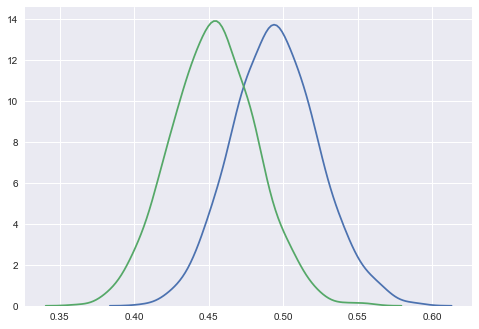

In [7]:
name = 'label_correlation'
ranks = np.load('./processed_data/'+str(year)+'_'+name+'.npy')
pat3 = list()
for _ in range(1000):
    sample = np.random.choice(ranks, 300)
    pat3.append((sample<=3).sum() / len(sample))
    
    
kdeplot(pat3)


name = 'nearest_neighbor'
ranks = np.load('./processed_data/'+str(year)+'_'+name+'.npy')
pat3 = list()
for _ in range(1000):
    sample = np.random.choice(ranks, 300)
    pat3.append((sample<=3).sum() / len(sample))
    
    
kdeplot(pat3)

In [41]:
def simple_bootstrap(data, n=1000, take = 350):
    return (np.random.choice(data, size=(n,take))<=3).sum(1) /take

def simple_ci(data):
    d_sorted = np.sort(data)
    low = int(d_sorted.shape[0] // (1/0.025))
    high = int(d_sorted.shape[0] // (1/0.975))
    return (d_sorted[low], d_sorted[high])

def simple_ecdf(ranks, maxrank):
    x = np.arange(1, maxrank)
    ecdf = [(ranks<=i).sum()/len(ranks) for i in x]
    return x, ecdf

In [42]:
bstrap = simple_bootstrap(ranks)
ci = simple_ci(bstrap)
x,y = simple_ecdf(ranks, 243)

In [67]:
def plot(nn=False):
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.set_figheight(10)
    fig.set_figwidth(7)
    if nn:
        nnranks = np.load('./processed_data/2015_nearest_neighbor.npy')
        mask = nnranks>3
    for count, name in enumerate(filenames):
        #load
        ranks = np.load('./processed_data/'+str(year)+'_'+name+'.npy')
        if nn:
            ranks = ranks[mask]
    
        #analyse
        bstrap = simple_bootstrap(ranks, take=len(ranks))
        ci = simple_ci(bstrap)
        x,y = simple_ecdf(ranks, 243)
    
        #plot:
        #A
        ax[0].plot(x,y,'-o', mfc='white', mew=1.5, linewidth=1.5,label=name, c='C'+str(count))
    
        #B
        out = kdeplot(bstrap, ax=ax[1], shade=True, color='C'+str(count))
        jit = np.random.uniform()*3+1
        ax[1].plot([ci[0], ci[1]], [-jit,-jit], lw=5.5, c='C'+str(count),zorder=10)
        ax[1].scatter([np.mean(ci)], [-jit], 
                       facecolor='white', 
                       edgecolor='C'+str(count),
                       lw=3.5,
                       zorder=20)
    
    ax[1].plot([0.3, 0.5], [1e6, 1e6], c='black', linewidth=3.5, label='95% CI')
    ax[1].set_ylim(-5,25)
    ax[1].set_xlim(-0.01, 0.6)
    ax[1].legend()
    
    plot_fig_label(ax[0], 'A.')
    plot_fig_label(ax[1], 'B.')

    ax[0].legend()    
    ax[0].set_xlim(0,20)
    return fig, ax

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


(<Figure size 504x720 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

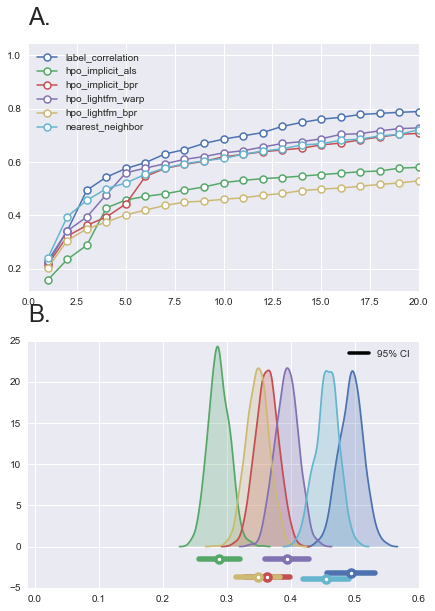

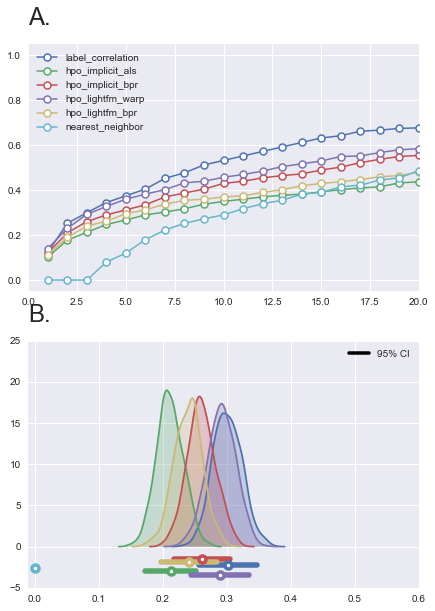

In [68]:
plot(nn=False)
plot(nn=True)

In [56]:
samples = np.random.choice(np.arange(1,10), 10000)
below_4 = samples<4
r = samples[below_4]

In [63]:
counting = list()
for i in range(10000):
    choice = np.random.choice(samples,3)
    success = min(choice)<4
    counting.append(success)

In [66]:
sum(counting) / len(counting)

0.7124

(array([1155.,    0.,    0.,    0.,    0., 1062.,    0.,    0.,    0.,
        1118.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

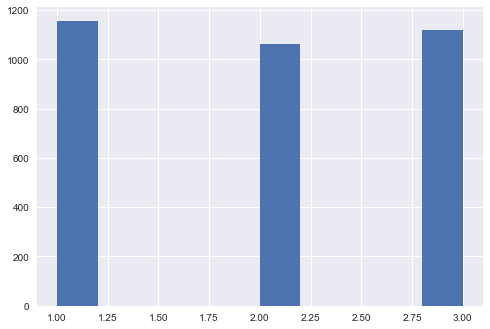

In [58]:
plt.hist(r)